In [1]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
#!pip install torchio

import tensorflow as tf
#for neuroimaging data
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
from tempfile import TemporaryDirectory


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
root_dir = 'Dataset'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri = tio.ScalarImage(file_path),
                    id = str(os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(file_path)))).replace('sub-', ''))
                )
                dataset.append(subject)
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

# print the path of the first image
print('\nFirst Image Path in Dataset: ')
print(dataset[0].mri.path)
print('ID:', dataset[0]['id'])

print('\nFirst Image Dimensions in Dataset: ')
print(dataset[0].spatial_shape)


Number of Images in Dataset: 621

First Image Path in Dataset: 
Dataset\NYU\sub-0010001\ses-1\anat\sub-0010001_ses-1_run-1_T1w.nii.gz
ID: 0010001

First Image Dimensions in Dataset: 
(128, 256, 256)


In [15]:
# check if a file named participants.tsv exists in the each of the subfolder under the root directory
# If it exists, load the file and display the contents
df = pd.DataFrame()
for subdir in subdirectories:
    if os.path.exists(os.path.join(subdir, 'participants.csv')):
        print('Found participants.csv in ' + subdir)
        new_df = pd.read_csv(os.path.join(subdir, 'participants.csv'), sep=',', header=0)
        new_df = new_df[['participant_id', 'age', 'gender', 'dx']]
        df = pd.concat([df, new_df], ignore_index=False)

# Print the resulting DataFrame
df.head()


Found participants.csv in Dataset\NYU
Found participants.csv in Dataset\OHSU
Found participants.csv in Dataset\Peking_1
Found participants.csv in Dataset\Peking_2
Found participants.csv in Dataset\Peking_3


,participant_id,age,gender,dx
0,21002,11.72,Male,ADHD-Combined
1,21003,9.11,Female,ADHD-Inattentive
2,21005,11.03,Male,Typically Developing Children
3,21006,9.81,Male,ADHD-Combined
4,21007,10.52,Male,Typically Developing Children


In [4]:
# Assign each row of the df to the corresponding subject in the dataset
for subject in dataset:
    subject_id = subject['id']
    if subject_id not in df['participant_id'].values:
        print(subject_id + ' dataframe does not have this subject_id')
    subject['age'] = df.loc[df['participant_id'] == subject_id, 'age'].values[0]
    subject['gender'] = df.loc[df['participant_id'] == subject_id, 'gender'].values[0]
    subject['dx'] = df.loc[df['participant_id'] == subject_id, 'dx'].values[0]


In [5]:
for subject in dataset:
    if subject['dx'] != 'Typically Developing Children':
        subject['dx'] = 'ADHD'

## Exploratory Data Analysis

In [6]:
## Number of subject in the dataset
print('Number of subjects in the dataset: ' + str(len(dataset)))

Number of subjects in the dataset: 621


C:\Users\Gelo\AppData\Local\Temp\ipykernel_2904\605367931.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, dx_counts[i], str(dx_counts[i]), ha='center', va='bottom')


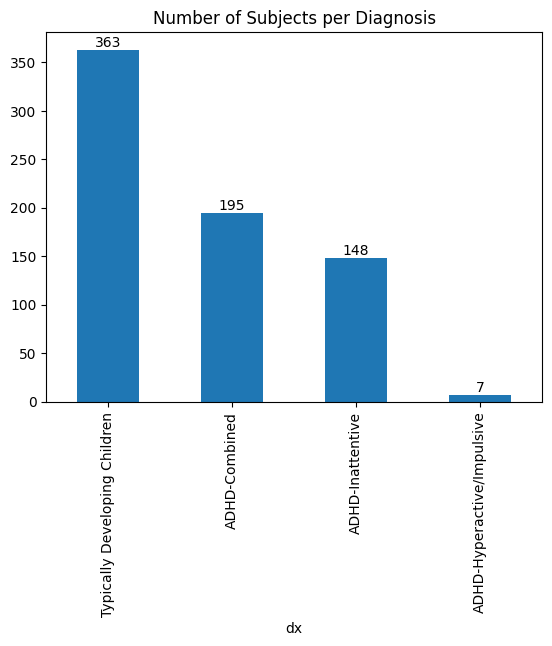

Number of subjects with ADHD: 297


In [7]:
#ADHD and Typically Developing Children
dx_counts = df['dx'].value_counts()

dx_counts.plot(kind='bar', title='Number of Subjects per Diagnosis')
# Add the count at the top of each bar
for i in range(len(dx_counts)):
    plt.text(i, dx_counts[i], str(dx_counts[i]), ha='center', va='bottom')
plt.show()


#Number of subject where dx is ADHD
print('Number of subjects with ADHD: ' + str(len([subject for subject in dataset if subject['dx'] != 'Typically Developing Children'])))

In [8]:
#Average age of the subjects
ages = [subject['age'] for subject in dataset]
average_age = np.mean(ages)
print('Average Age of the subjects: ' + str(average_age))



Average Age of the subjects: 11.121610305958132


C:\Users\Gelo\AppData\Local\Temp\ipykernel_2904\2684944687.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, gender_counts[i], str(gender_counts[i]), ha='center', va='bottom')


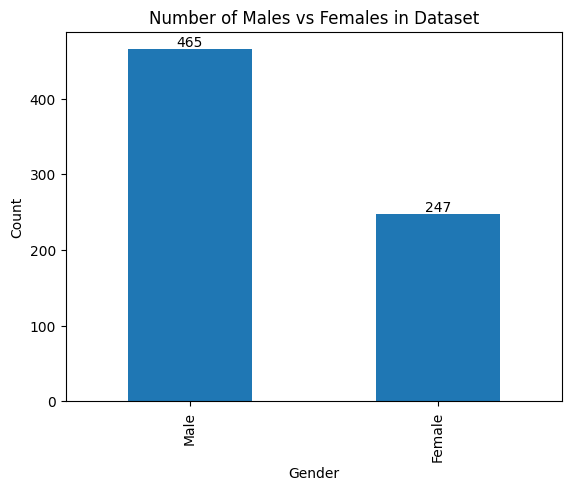

Number of Males in the dataset: 405
Number of Females in the dataset: 215


In [9]:
# Count the number of males and females in the dataset
gender_counts = df['gender'].value_counts()

# Create a bar graph to visualize the counts
gender_counts.plot(kind='bar')

# Add the count at the top of each bar
for i in range(len(gender_counts)):
    plt.text(i, gender_counts[i], str(gender_counts[i]), ha='center', va='bottom')
# Add labels and title to the graph
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Number of Males vs Females in Dataset')

# Display the graph
plt.show()


# Print the number of Gender = male in the dataset
print('Number of Males in the dataset: ' + str(len([subject for subject in dataset if subject['gender'] == 'Male'])))
print('Number of Females in the dataset: ' + str(len([subject for subject in dataset if subject['gender'] == 'Female'])))




In [10]:
shapes = set()
count = 0
for subject in dataset:
    shapes.add(subject['mri'].shape)
    count += 1
print("Unique shape values in the dataset:")
print(shapes)
print("Number of unique shape values in the dataset:")
print(len(shapes))

Unique shape values in the dataset:
{(1, 176, 208, 256), (1, 128, 256, 256), (1, 128, 240, 256), (1, 160, 240, 256), (1, 192, 256, 256), (1, 176, 512, 512), (1, 46, 240, 256)}
Number of unique shape values in the dataset:
7


In [11]:
voxel_spacing = set()
for subject in dataset:
    voxel_spacing.add(subject['mri'].spacing)

print("Unique voxel spacing values in the dataset:")
for spacing in voxel_spacing:
    print(spacing)

print("Number of unique voxel spacing values in the dataset:")
print(len(voxel_spacing))


Unique voxel spacing values in the dataset:
(1.3300018310546875, 1.0, 1.0)
(1.0, 1.0000001192092896, 1.0000001192092896)
(1.3300000429153442, 1.0, 1.0)
(1.100000023841858, 1.0, 0.9999999403953552)
(1.1000001430511475, 1.0, 1.0)
(1.0999999046325684, 0.9999999403953552, 1.0)
(1.0, 1.0, 1.0)
(1.100000023841858, 0.9999999403953552, 1.0)
(1.0, 0.5, 0.5)
(1.0, 1.0000004768371582, 1.0000004768371582)
(1.0, 0.9375, 0.9375)
(1.3300001621246338, 1.0, 1.0)
(1.3299942016601562, 1.0, 1.0)
(1.0, 0.9999996423721313, 0.9999996423721313)
(1.0999999046325684, 1.0, 1.0)
(0.9999998211860657, 1.0000003576278687, 3.299999952316284)
(1.2999999523162842, 1.0, 1.0)
(1.100000023841858, 1.0, 1.0)
(1.3299999237060547, 1.0, 1.0)
(1.0999999046325684, 1.0, 0.9999999403953552)
(1.3300000429153442, 0.99609375, 0.99609375)
Number of unique voxel spacing values in the dataset:
21


In [12]:
count_mean = 0
std_dev = 0
for subject in dataset:
    image_tensor =  subject['mri'].data
    count_mean += torch.mean(image_tensor.float())  
    std_dev += torch.std(image_tensor.float())

average_mean = count_mean/len(dataset)
average_std = std_dev/len(dataset)
print(f'Average Mean of the Dataset: {average_mean:.4f}, Standard Deviation: {average_std:.4f}')


Average Mean of the Dataset: 46.7788, Standard Deviation: 77.0929


Subject ID: 10001
Age: 11.17
Gender: Female
Diagnosis: ADHD


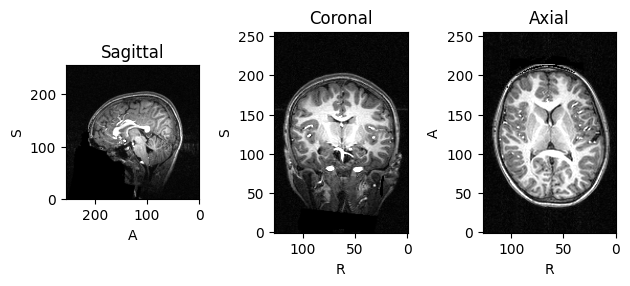

Subject ID: 10002
Age: 13.24
Gender: Female
Diagnosis: ADHD


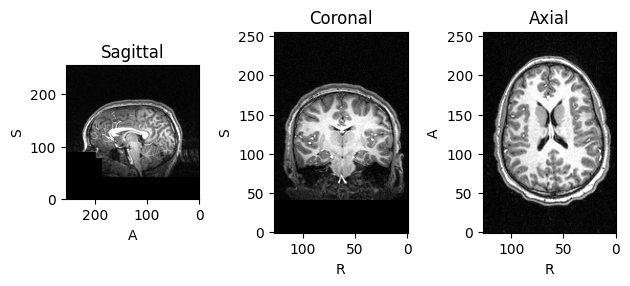

Subject ID: 10003
Age: 9.29
Gender: Female
Diagnosis: Typically Developing Children


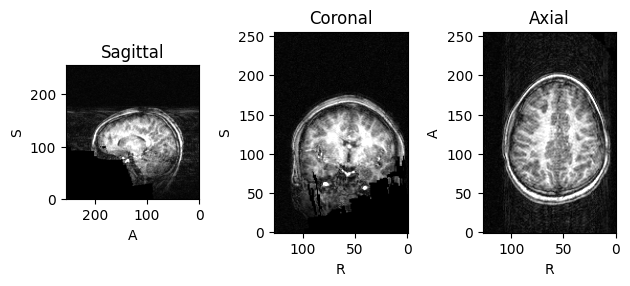

Subject ID: 10004
Age: 13.75
Gender: Female
Diagnosis: Typically Developing Children


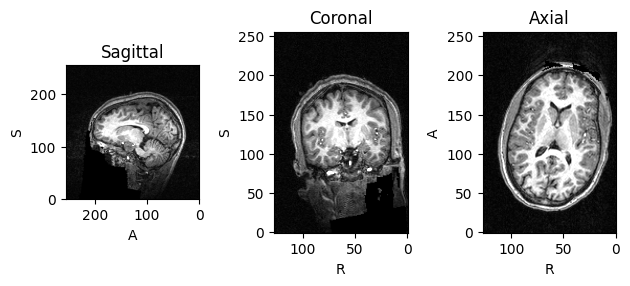

Subject ID: 10005
Age: 11.92
Gender: Male
Diagnosis: ADHD


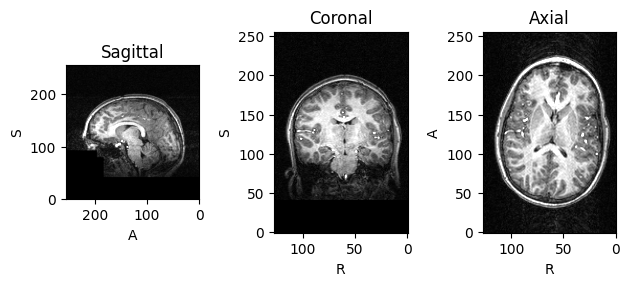

In [13]:
for i in range(5):
    subject = dataset[i]
    image = subject['mri']
    print('Subject ID:', subject['id'])
    print('Age:', subject['age'])
    print('Gender:', subject['gender'])
    print('Diagnosis:', subject['dx'])
    image.plot()
    plt.show()

